# Connect to database

In [1]:
import os
import psycopg2 # PostgreSQL database adapter for Python
from dotenv import load_dotenv # Reads the key-value pair from .env file and adds them to environment variable

# Load environment variables from .env file
load_dotenv()

# Accessing credentials
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [2]:
# Connect to the database
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

# Retrieve relevant data from the database

In [3]:
query="""
    select TO_TIMESTAMP(year || '-' || month || '-' || day || ' ' || hour || ':' || min, 'YYYY-MM-DD HH24:MI') AT TIME ZONE 'UTC' as ts,
    gridimport_wh - gridexport_wh as net_load  
    from agg.t_msb1m  
    where site = 12
"""

In [4]:
import pandas as pd

df = pd.read_sql_query(query, conn)

C:\Users\elian\AppData\Local\Temp\ipykernel_33140\2309603890.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38036 entries, 0 to 38035
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ts        38036 non-null  datetime64[ns]
 1   net_load  38036 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 594.4 KB


In [6]:
df

,ts,net_load
0,2019-03-01 15:15:00,1011.03
1,2019-03-01 15:30:00,797.85
2,2019-03-01 15:45:00,512.28
3,2019-03-01 16:00:00,241.41
4,2019-03-01 16:15:00,137.48
...,...,...
38031,2020-03-31 22:45:00,8.49
38032,2020-03-31 23:00:00,8.70
38033,2020-03-31 23:15:00,8.67
38034,2020-03-31 23:30:00,8.52


In [7]:
# Convert 'ts' to datetime and set as index
df['ts'] = pd.to_datetime(df['ts'])
df.set_index('ts', inplace=True)

df

,net_load
ts,
2019-03-01 15:15:00,1011.03
2019-03-01 15:30:00,797.85
2019-03-01 15:45:00,512.28
2019-03-01 16:00:00,241.41
2019-03-01 16:15:00,137.48
...,...
2020-03-31 22:45:00,8.49
2020-03-31 23:00:00,8.70
2020-03-31 23:15:00,8.67


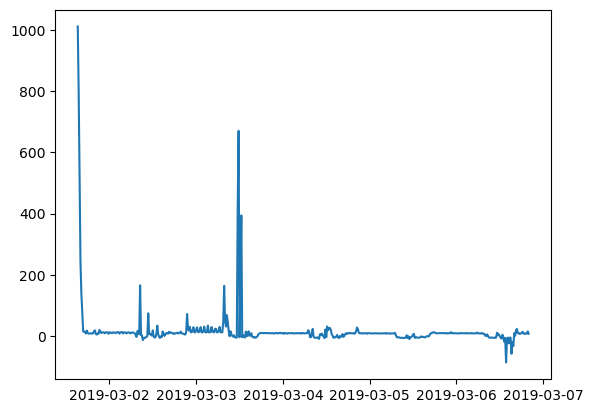

In [10]:
import matplotlib.pyplot as plt
plt.plot(df.index[0:500], df.net_load[0:500])
plt.show()

# Normalise net load

In [8]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalise the 'net_load' values using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df['net_load_norm'] = scaler.fit_transform(df[['net_load']])

df

,net_load,net_load_norm
ts,,
2019-03-01 15:15:00,1011.03,0.915236
2019-03-01 15:30:00,797.85,0.806956
2019-03-01 15:45:00,512.28,0.661906
2019-03-01 16:00:00,241.41,0.524322
2019-03-01 16:15:00,137.48,0.471533
...,...,...
2020-03-31 22:45:00,8.49,0.406015
2020-03-31 23:00:00,8.70,0.406122
2020-03-31 23:15:00,8.67,0.406106


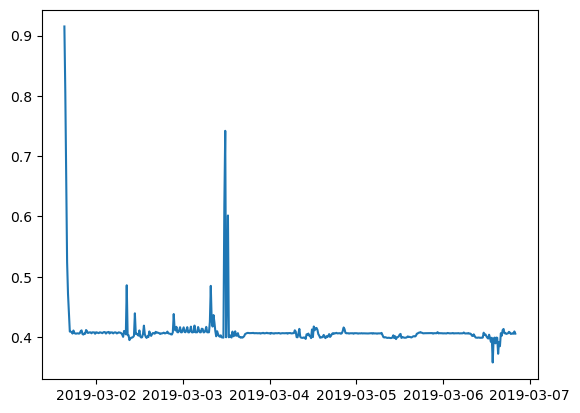

In [17]:
import matplotlib.pyplot as plt
plt.plot(df.index[0:500], df.net_load_norm[0:500])
plt.show()

# Generate additional features

##  1. Lagged values: 4 hours, 8 hours, 12 hours, 16 hours, 20 hours, 24 hours, 32 hours

In [23]:
# Each hour has 4 observations (15 min intervals), so we multiply the hours by 4 to get the lag steps
hours = [4, 8, 12, 16, 20, 24, 32]
lags = [h * 4 for h in hours]  # Convert hours to number of 15-min intervals

for lag in lags:
    df[f'net_load_norm_lag_{lag}'] = df['net_load_norm'].shift(lag)

df

,net_load,net_load_norm,net_load_norm_lag_16,net_load_norm_lag_32,net_load_norm_lag_48,net_load_norm_lag_64,net_load_norm_lag_80,net_load_norm_lag_96,net_load_norm_lag_128
ts,,,,,,,,,
2019-03-01 15:15:00,1011.03,0.915236,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-01 15:30:00,797.85,0.806956,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-01 15:45:00,512.28,0.661906,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-01 16:00:00,241.41,0.524322,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-01 16:15:00,137.48,0.471533,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2020-03-31 22:45:00,8.49,0.406015,0.405654,0.348659,0.409347,0.405893,0.406122,0.405578,0.358290
2020-03-31 23:00:00,8.70,0.406122,0.406467,0.337068,0.405923,0.405944,0.405629,0.406061,0.350894
2020-03-31 23:15:00,8.67,0.406106,0.405004,0.339964,0.409896,0.404715,0.406020,0.406274,0.360179


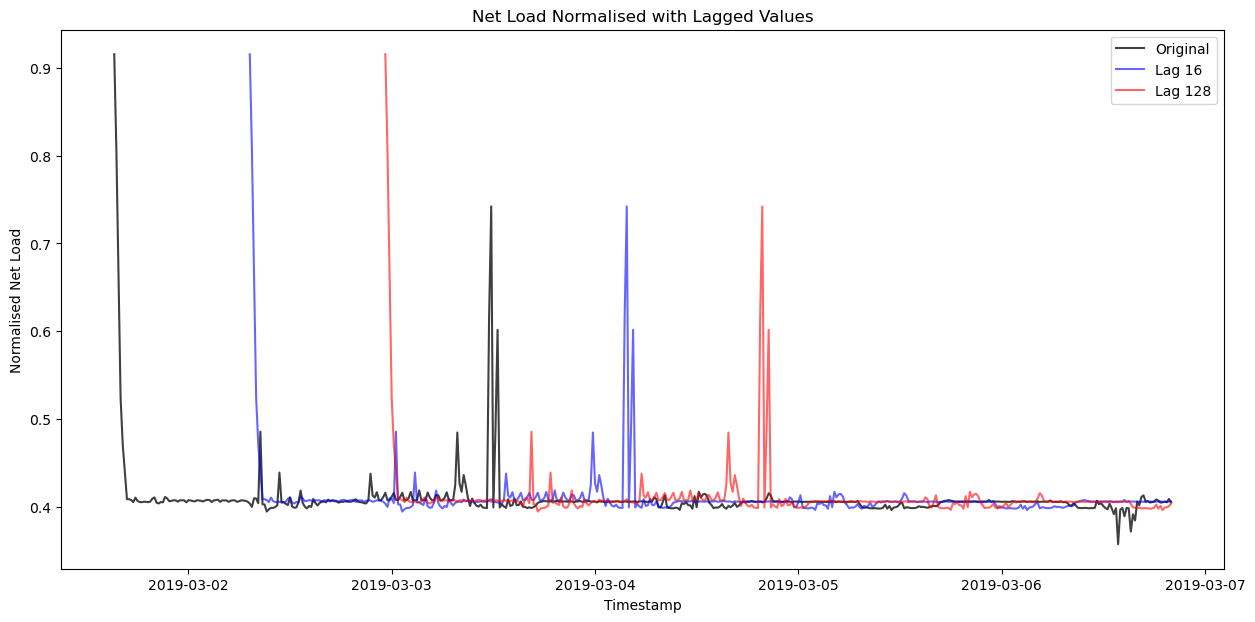

In [34]:
plt.figure(figsize=(15, 7))

# Original net_load_norm
plt.plot(df.index[0:500], df['net_load_norm'][0:500], label='Original', alpha=0.75, color='black')

# 16 hours lag
plt.plot(df.index[0:500], df['net_load_norm_lag_64'][0:500], label='Lag 16', alpha=0.6, color='blue')

# 16 hours lag
plt.plot(df.index[0:500], df['net_load_norm_lag_128'][0:500], label='Lag 128', alpha=0.6, color='red')

plt.title('Net Load Normalised with Lagged Values')
plt.xlabel('Timestamp')
plt.ylabel('Normalised Net Load')
plt.legend()
plt.show()

## 2. Type of day i.e., Monday, Tuesday,.., Sunday